## Introduction

The titles included in the bibliography tell us a few things, for instance the language a publication is written in or the main themes (keywords, authors) that is the subject of a publication. Let's find out about them. (The code below initializes the analyis.)

In [5]:
# === Imports === 

# Basics
import re 
from os.path import realpath, dirname, join
import os
from lxml import etree
from collections import Counter
import pandas as pd

# Visualization
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt


# === Files and parameters === 

wdir  = join("/", "media", "christof", "Data", "Github", "christofs", "bib18")
#Bib18_file = join(wdir, "data", "Bib18_test.rdf") 
Bib18_file = join(wdir, "data", "Bib18.rdf") 

namespaces = {
    "foaf" : "http://xmlns.com/foaf/0.1/",
    "bib" : "http://purl.org/net/biblio#",
    "dc" : "http://purl.org/dc/elements/1.1/",
    "z" : "http://www.zotero.org/namespaces/export#",
    "rdf" : "http://www.w3.org/1999/02/22-rdf-syntax-ns#"
    }


## Extracting the titles

The first step is to identify the titles in the dataset. Ideally, we would exclude titles of journals, for instance, but this is not done here yet. 

In [2]:
def read_json(Bib18_file): 
    """
    Open and read the RDF version of the Bib18 dataset.
    Returns: the XML document as an etree object. 
    """
    Bib18 = etree.parse(Bib18_file)
    return Bib18


def get_titles(Bib18): 
    """
    Extract all the primary titles from the dataset. 
    Primary titles are all titles except journal names. 
    """
    # Find all primary "title" elements in the dataset 
    # TODO: find the XPath to exclude journal titles. 
    xpath = "//dc:title/text()"
    titles = Bib18.xpath(xpath, namespaces=namespaces)
    print("Number of titles found: " + str(len(titles)) + ".")
    return titles

# === Main === 

def main(): 
    global Bib18   
    Bib18 = read_json(Bib18_file)
    global titles 
    titles = get_titles(Bib18)
main()


Number of titles found: 110174.


## Distribution of languages, based on the titles

We don't have abstracts or full texts in the dataset, but on the basis of the titles alone, the (most likely) language of the publication can be determined. (Note that an algorithmic process, based on the library py-lingua and using only the sometimes very short titles, has been used to create this data, so errors are to be expected. With the progress of corrections in the dataset, this will improve over time.)

The following table shows the number of times several different languages occur in the dataset.


In [3]:
def get_lang_counts(Bib18): 
    """
    Extract all the language elements from the dataset. 
    Then, establish the counts of the languages. 
    """
    # Find all "language" elements in the dataset. 
    xpath = "//z:language/text()"
    langs = Bib18.xpath(xpath, namespaces=namespaces)
    print("Number of language indications found: " + str(len(langs)) + ".")

    # Establish the counts of each language
    lang_counts = dict(Counter(langs))
    lang_counts = pd.DataFrame.from_dict(lang_counts, orient="index").reset_index().rename(mapper={"index":"language", 0 : "count"}, axis="columns")
    lang_counts.sort_values(by="count", ascending=False, inplace=True)

    # Display the table nicely
    display(lang_counts.head(10).style.hide(axis="index"))

    # Save the data to a CSV file (as runtime is long)
    with open(join(wdir, "data", "lang_counts.csv"), "w", encoding="utf8") as outfile: 
        lang_counts.to_csv(outfile)

    # Return data
    return lang_counts

global lang_counts
lang_counts = get_lang_counts(Bib18)

Number of language indications found: 64396.


language,count
French,47579
English,13348
Italian,958
German,915
Spanish,866
Dutch,282
Swedish,231
Portuguese,217


Let's visualize this data as well. 

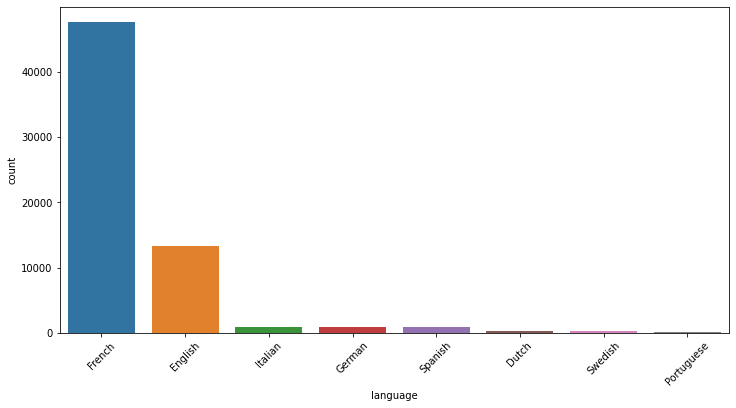

In [9]:
def visualize_tlc(lang_counts): 
    """
    Create a visualization (barplot) of the languages counts. 
    """
    #fig = px.bar(
    #    lang_counts.head(10), 
    #    x="language", 
    #    y="count", 
    #    title="Distribution of languages in the titles",
    #    text_auto=True)
    #fig.show(renderer="notebook")

    plt.figure(figsize=(12,6))
    fig = sns.barplot(
        data=lang_counts.head(10), 
        x="language", 
        y="count")
    fig.set_xticklabels(fig.get_xticklabels(), rotation=30)
    plt.savefig(join(wdir, "figures", "language_counts.svg"))
    plt.show()



visualize_tlc(lang_counts)


The dominance of French is very clear, followed by English. As noted above, this analysis will be strongly improved with manual corrections to the language information.  